In [76]:
import pandas as pd
import numpy as np

import random
from sklearn import metrics # for the evaluation
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


In [77]:
listControl = []
listPatient = []

#Reads in each of the 8 sheets for the patient and the control datasets
for i in range(1,9):
    #Imports the patient dataset and drops unneccessary rows/columns
    df = pd.read_excel('ALL_PMS_Patient_Biolog_data_NORMALIZED.xlsx', sheet_name='PM-M' + str(i))
    df = df[1:]
    df.columns = df.iloc[0]
    df = df[1:]
    df = df.drop('well', axis=1)
    dfNames = df['CMS#']
    df = df.drop('CMS#', axis=1)

    #Imports the control dataset and removed unnecessary rows/columns
    df_control = pd.read_excel('ABS_Normalized Control_PMS data.xlsx', sheet_name='PM-M' + str(i) + '_Control')
    df_control = df_control[4:]
    cols = df_control.columns.tolist()
    to_remove = cols[0:59] + cols[109:]
    df_control = df_control.loc[:, ~df_control.columns.isin(to_remove)]

    #Converts to numpy array and adds the numpy array to a list
    arrayControl = df_control.to_numpy()
    arrayPatient = df.to_numpy()

    #Appends the array to a list
    listControl.append(arrayControl)
    listPatient.append(arrayPatient)

In [78]:
#Converts the lists to arrays and reshapes the arrays to be 2-dimensional instead of 3-dimensional
arrayControl_3D = np.array(listControl)
arrayControl = arrayControl_3D.reshape(-1,50)
arrayPatient_3D = np.array(listPatient)
arrayPatient = arrayPatient_3D.reshape(-1,48)

print(arrayControl.shape)
print(arrayPatient.shape)

(768, 50)
(768, 48)


In [79]:
medianDifference = []
meanDifference = []

#Calculate difference of the control median and patient median per well and appends value to the list
for i in range(0,768):
    controlMedian = np.median(arrayControl[i])
    patientMedian = np.median(arrayPatient[i])
    medianDifference.append(controlMedian-patientMedian)

    controlMean = np.mean(arrayControl[i])
    patientMean = np.mean(arrayPatient[i])
    meanDifference.append(controlMean-patientMean)

#Converts the list to a NumPy array
Mean = np.array(meanDifference)
Median = np.array(medianDifference)
print(np.median(abs(Mean)))
print(np.median(abs(Median)))

0.24432858029483007
0.2609712967231488


In [80]:
#In this case, we will use the first 50 columns as the control and the last 48 columns as the patient
x_array = np.append(arrayControl, arrayPatient, 1)

#Creates a set of values in the median differences array that are between -0.2 and 0.2 and deletes the values from x_array
toDrop = np.where(abs(Median) < 0.5)
x_array = np.delete(x_array, toDrop, 0)

#transposes the x_array
x_array_transpose = np.transpose(x_array)
print(x_array_transpose.shape)

#Creates a corresponding y array where 0 is control and 1 is patient
y_array = np.append(np.zeros(50), np.ones(48)) 
print(y_array.shape)

(98, 254)
(98,)


In [81]:
listAccuracyScore = []
listLogLossScore = []
listRecallScore = []
listPrecisionScore = []
listROCAUCScore = []
listConfusionMatrices =[]

#Runs the logistic regression 100 times and calculates the accuracy score
for i in range (0,100):
    #Randomly shuffles the x and y data while keeping matching order
    temp = list(zip(x_array_transpose, y_array))
    random.shuffle(temp)
    x_shuffled, y_shuffled = zip(*temp)
    x_shuffled = np.array(x_shuffled)
    y_shuffled = np.array(y_shuffled)

    #Splits data into train and test split
    x_train = x_shuffled[0:80]
    x_test = x_shuffled[80:99]
    y_train = y_shuffled[0:80]
    y_test = y_shuffled[80:99]

    # Fitting Logistic Regression to the Training set
    lr = LogisticRegression(solver="liblinear", max_iter=10000)
    lr.fit(x_train, y_train)

    # Predicting the Test set results
    y_pred = lr.predict(x_test)
    y_pred_proba =lr.predict_proba(x_test)
    listAccuracyScore.append(metrics.accuracy_score(y_test, y_pred))
    listLogLossScore.append(metrics.log_loss(y_test, y_pred_proba))
    listRecallScore.append(metrics.recall_score(y_test, y_pred))
    listPrecisionScore.append(metrics.precision_score(y_test, y_pred))
    listROCAUCScore.append(metrics.roc_auc_score(y_test, y_pred))
    listConfusionMatrices.append(metrics.confusion_matrix(y_test, y_pred))

print("Accuracy: " + str(np.mean(listAccuracyScore)))
print("Log Loss: Mean: " + str(np.mean(listLogLossScore)) + "  Median: " + str(np.median(listLogLossScore)))
print("Recall: " + str(np.mean(listRecallScore)))
print("Precision: " + str(np.mean(listPrecisionScore)))
print("ROC-AUC: " + str(np.mean(listROCAUCScore)))

Accuracy: 0.7938888888888889
Log Loss: Mean: 0.7501297605597216  Median: 0.7105240079891715
Recall: 0.8306430236430234
Precision: 0.7689469974469975
ROC-AUC: 0.796527972027972


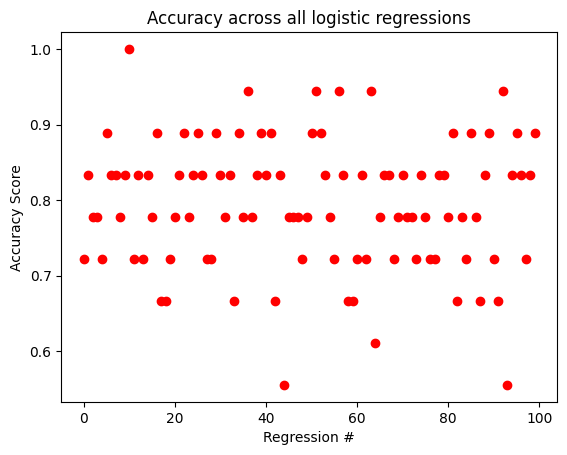

In [82]:
plt.title("Accuracy across all logistic regressions")
plt.xlabel("Regression #")
plt.ylabel("Accuracy Score")
plt.plot(listAccuracyScore, 'ro', scalex=True)
plt.show()

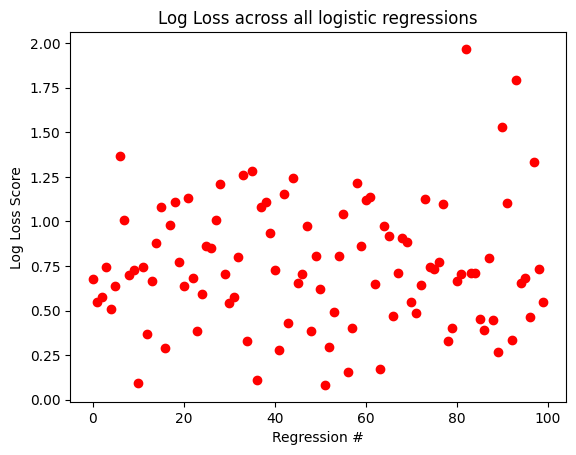

In [83]:
plt.title("Log Loss across all logistic regressions")
plt.xlabel("Regression #")
plt.ylabel("Log Loss Score")
plt.plot(listLogLossScore, 'ro')
plt.show()

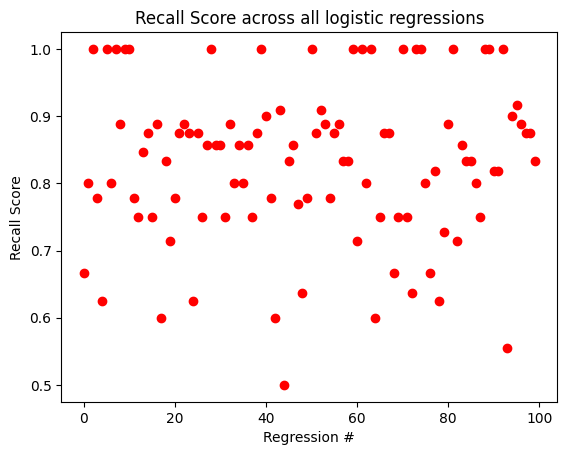

In [84]:
plt.title("Recall Score across all logistic regressions")
plt.xlabel("Regression #")
plt.ylabel("Recall Score")
plt.plot(listRecallScore, 'ro')
plt.show()

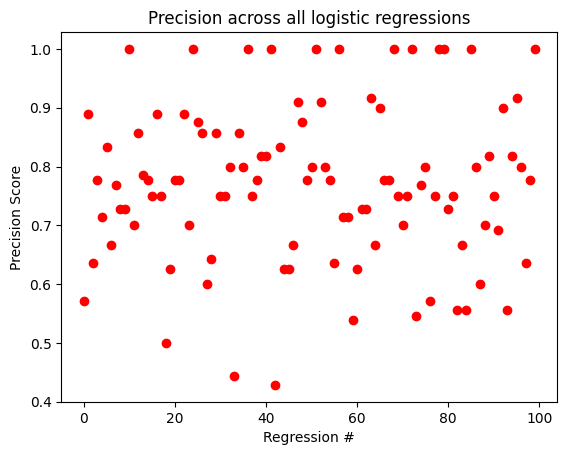

In [85]:
plt.title("Precision across all logistic regressions")
plt.xlabel("Regression #")
plt.ylabel("Precision Score")
plt.plot(listPrecisionScore, 'ro')
plt.show()

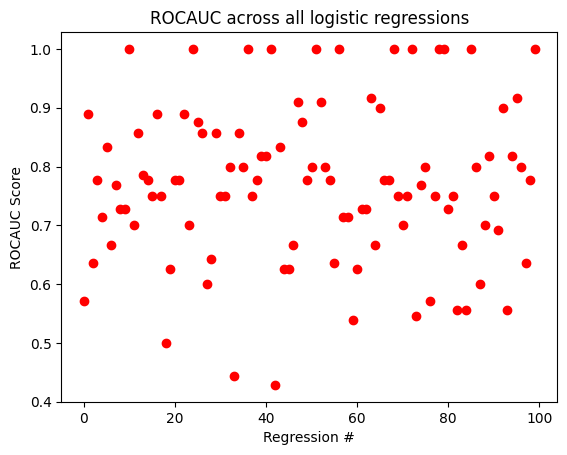

In [86]:
plt.title("ROCAUC across all logistic regressions")
plt.xlabel("Regression #")
plt.ylabel("ROCAUC Score")
plt.plot(listPrecisionScore, 'ro')
plt.show()